# Dimentional Reduction

process of reducing the number of variable/features 


 # Dimensionality Reduction Visualizations


First, we need to import numpy, matplotlib, and scikit-learn and get the UCI ML digit image data. Scikit-learn already comes with this data (or will automatically download it for you) so we don’t have to deal with uncompressing it ourselves! Additionally, I’ve provided a function that will produce a nice visualization of our data.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import offsetbox 


In [3]:
from sklearn import datasets
digits = datasets.load_digits()
X = digits.data
y = digits.target
n_samples, n_features = X.shape
print("number of samples:", n_samples)
print("number of features:", n_features)

number of samples: 1797
number of features: 64


#### Degits

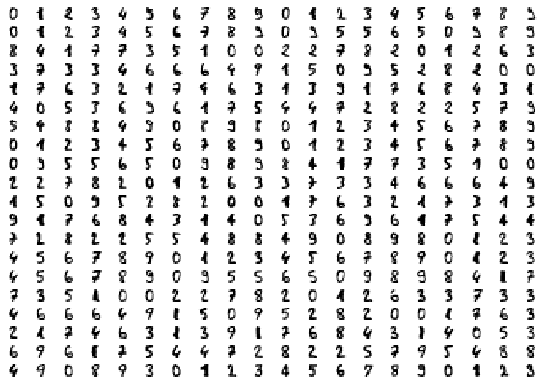

In [4]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [0]:
def embedding_plot(X,labels,title):
  plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Spectral', s=5)
  plt.gca().set_aspect('equal', 'datalim')
  plt.gca().set_facecolor((1, 1, 1))
  plt.xlabel('1st dimension')
  plt.ylabel('2nd dimension')
  plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
  plt.grid(False)
  plt.title(title, fontsize=24);

Using any of the dimensionality reduction techniques that we’ve discussed in scikit-learn is trivial! We can get PCA working in just a few lines of code!

## Principal Component Analysis (PCA)
Principal component analysis creates new orthogonal variables (principle components) that are linear combinations of the original variables. The focus of PCA is to reproduce the total variance in the original higher dimensional space in the lower dimensional space.
PCA is an optimum approach for mapping to the lower dimensional space and be able to reconstruct the original space afterward.

1) The first principal component (PC) corresponds to a line that passes through the mean. The lines is the regression line so that it minimizes the sum of squares of the distances of the points from the line. 

2) The second PC corresponds to the same concept after all correlation with the first principal component has been subtracted from the points.


**Assumptions**
* Euclidean distance between points (not approapriate always such as for counts of abundance)
* Assume a linear relationship between variables (if data are nonlinear, PCA produces an artifact called "horseshoe effect" in which axis 2 is twisted relative to axis 1)

**PCA is an unsupervised approach. We add color for the sample labels afterward.**

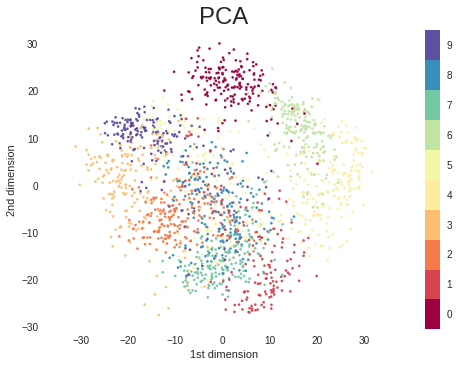

In [0]:
from sklearn import decomposition

X_pca = decomposition.PCA(n_components=2).fit_transform(X)
embedding_plot(X_pca, y,"PCA")


Text(0, 0.5, 'variance explained')

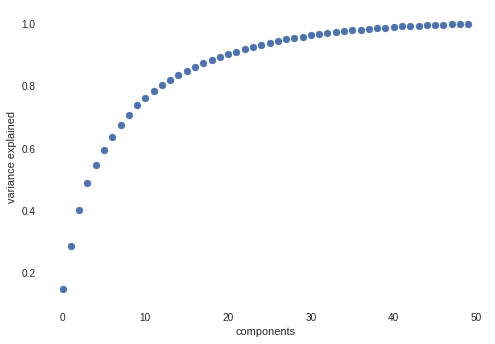

In [0]:
component_num = 50
pca = decomposition.PCA(n_components=component_num,svd_solver='full')
pca.fit_transform(X)

plt.scatter(range(0,component_num),np.cumsum(pca.explained_variance_ratio_))
plt.gca().set_facecolor((1, 1, 1))
plt.xlabel('components')
plt.ylabel('variance explained')

# Independent Component Analysis (ICA)
ICA looks to find independent factors in the set of features while PCA looks for uncorrelated factors. ICA assumes that there are mutually independent latent variables that can be linearly combined to build the original set of given variables (features).

  * Independent: P(X|Y)=P(X)
  * Uncorrelated: (usually) Pearson correlation=0 => covariance between X and Y is 0
  
**Theorem**. If two random variables X and Y are independent, then they are uncorrelated.
Reverse is not true.

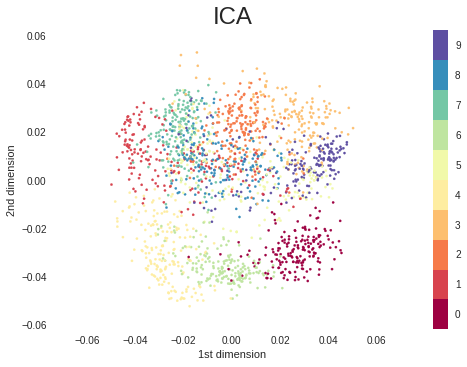

In [0]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=2, random_state=5).fit_transform(X) 
embedding_plot(ICA, y,"ICA")

### Comparison of PCA and ICA using synthetic data

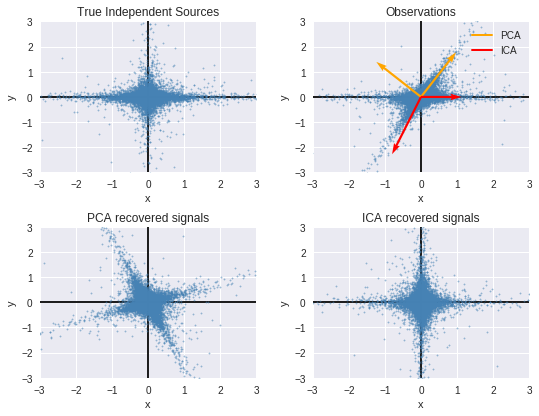

In [0]:
from sklearn.decomposition import PCA,FastICA
# #############################################################################
# Generate sample data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations

pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

S_ica_ /= S_ica_.std(axis=0)


# #############################################################################
# Plot results

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6,
                       color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure()
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()


# t-distributed Stochastic Neighbor Embeding (t-SNE)

t-SNE is an algorithm to optimally map the higher dimensional space to lower dimensions paying attention to short distances. The trasformation is different for different regions. SNE is the general concept behind this type of mapping and "t" shows usage of t-distribution in t-SNE. 
There are some important points regarding parameter setting and interpretation of t-SNE output:

**Parameters:**

* ***Perplexity***: somehow shows the number of close neighbors each point has. Hence, perplexity should be smaller than the number of points. There is a suggested range for perplexity in the original paper: "The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.". Although perplexity=5 is usually not optimal, values higher than 50 also may result in weird grouping of the data points and shapes in 2 dimensional space. 

* ***Number of iterations*** required for converagence of the approach is another important parameter that depened on the input dataset. There are no fixed number to make sure of the convergence but there are some rule of thumb to check that. As an example, if there are pinched shapes in the t-SNE plot, it is better to run the approach for higher iteration number to makes sure that the resulted shapes and clusters are not artifacts of an unconverged t-SNE.

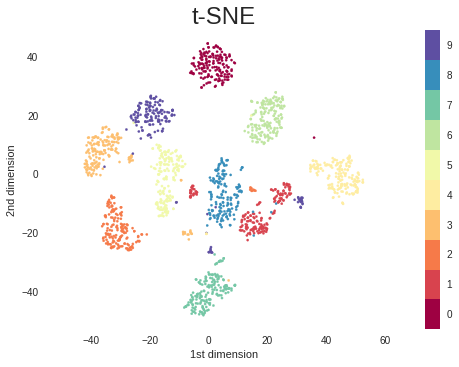

In [9]:
from sklearn import manifold

X_tsne = manifold.TSNE(n_components=2, init='pca',perplexity=30,learning_rate=200,n_iter=500).fit_transform(X)
embedding_plot(X_tsne, y,"t-SNE")

**Interpretation:**

* **Sizes of clusters in t-SNE do not have any meaning**: t-SNE contracts the sparse clusters while expands dense ones to even out the cluster sizes in the final layouts. 

* **Distances between the separated clusters do not have any meaning**: t-SNE tries to keep the data points, that are in proxity of each other in high dimensional space, close to each other in low dimensional space while not takeing care of the greater distances, distance between clusters, in the mapping.

* **We may get clusters from random data**: Different perplexity or iteration number may even resuls in clusters for random data. So when you see clusters in your 2D t-SNE output, it does not mean the input data are not randomly distributed.

# Uniform Manifold Approximation and Projection (UMAP)

UMAP is a manifold learning method that is comptetitive to t-SNE for visualization quality while preserving the global structure of data, unlike t-SNE. UMAP has no computational restriction and is scalable to extremely large dataset, like GoogleNews, unlike t-SNE.

UMAP uses k-nearest neighbor and uses Stochastic Gradient Descent to minimize the difference between the distances in the high dimensional and low dimensional spaces.


**Definitions**

* A n-dimensional manifold (n-manifold) M is a topological space that is locally homeomorphic to the Euclidean space of dimension n.
* Locally homeomorphic means that every point in the space M is contained in an open set U such that there is a one-to-one onto map f:U -> M.
* One-to-one onto map f:U -> M means that each element of M is mapped by exactly one element of U.
* A topological space is a collection of open sets (with some mathematical properties).
* A Riemannian (smooth) manifold M is a real smooth manifold with an inner product that varies smoothly from point to point in the tangent space of M.
* Riemannian metric is collection of all the inner products of the points in the manifold M on the tangent space of M.

* A simplicial complex K in n-dimensional real space is a collection of simplices in the space such that 1) Every face of a simplex of K is in K, and 2) The intersection of any two simplices of K is a face of each of them (Munkres 1993, p. 7; http://mathworld.wolfram.com/).
* A simplex is the generalization of a tetrahedral region of space to n dimensions(http://mathworld.wolfram.com/).

**Assumptions:**

Source: https://umap-learn.readthedocs.io/en/latest/
* The data is uniformly distributed on Riemannian manifold.
* The Riemannian metric is locally constant (or can be approximated as such).
* The manifold is locally connected.

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


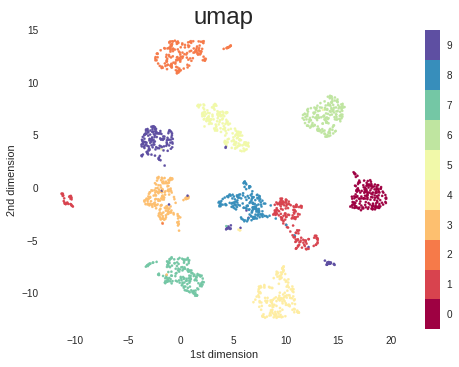

In [0]:
import umap

X_umap = umap.UMAP(n_neighbors=5, min_dist=0.4, n_components=2).fit_transform(X)
embedding_plot(X_umap, y,"umap")

## LDA

Now let’s use LDA  to visualize the same data. Just like PCA, using LDA in scikit-learn is very easy! Notice that we have to also give the class labels since LDA is supervised!

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


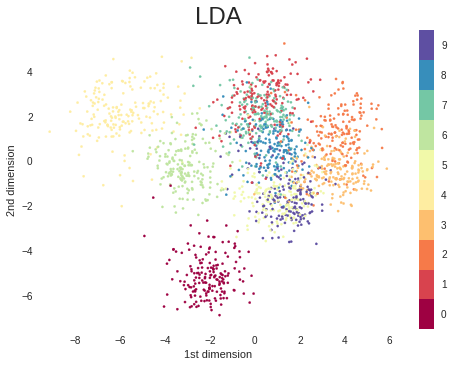

In [0]:
from sklearn import discriminant_analysis

X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
embedding_plot(X_lda,  y,"LDA")

### Combination of unsupervised and supervised methods
We can first reduce the dimensionality of the data using PCA, as an unsupervised appraoch, and then implement LDA.

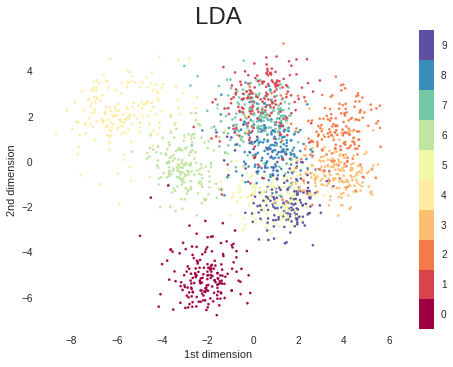

In [0]:
X_pca = decomposition.PCA(n_components=50).fit_transform(X)

X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X_pca, y)
embedding_plot(X_lda,  y,"LDA")